# Nest 3.4 code for Henderson, Keane and Gong (2018)

J. Royal Society Interface - Dynamical patterns underlying response properties of cortical circuits

https://royalsocietypublishing.org/doi/10.1098/rsif.2017.0960

Model implemented in NEST by daniel.naoumenko@sydney.edu.au
28 August 2023

In [1]:
import nest
import matplotlib.pyplot as plt
import numpy as np


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  6 2023 09:12:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Define model parameters

In [2]:
# 40 micron spacing
n=100 #length of square grid (in number of neurons)
I_e = 0.0

modelname = 'iaf_cond_exp'

modeldict = {'C_m':500.0,
             'V_m' : nest.random.uniform(-70.0,-50.0),
              'g_L':25.0,
              'E_ex':0.0,
               'E_in':-80.,
              'V_th':-55.,
              'V_reset':-70.,
               'E_L':-70.,
              't_ref':5.0,
              'I_e':400.,
              'tau_syn_ex':2.0,
               'tau_syn_in':2.0}

n_tot = n**2     #total population
n_ex = n**2     # size of the excitatory population
n_in = ((n+1)//2)**2      # size of the inhibitory population
#w_in = -g_syn*w_ex #weight of inhibitory input
#w_poisson_in = -g_noise * w_poisson_ex #weight of inhibitory external input
NEST_SpikeNet_conversion = 140 #conversion factor between simulators to equalise spike size
alpha = 1.65
crit_offset = -0. #bump model away from critical point
#inhibition dominated when R_I=30
# W_E = (0.13*alpha-crit_offset)*NEST_SpikeNet_conversion
# W_I = (-0.035*alpha)*NEST_SpikeNet_conversion

# W_E = (0.13*alpha-crit_offset)*NEST_SpikeNet_conversion
# W_I = (-0.035*alpha)*NEST_SpikeNet_conversion
# W_E = .230
# W_I = -.150

# W_E = 100./0.946*2
# W_I = 15.

# alpha = 1.65
# W_E = .13*alpha
# W_I = .035*alpha

W_E = 7.5e-3*1000
W_I = 5e-3*1000

#Normaliztion factor and convert to nS
#W_E = W_E*0.31498*1000
#W_I = W_I*0.11661*1000

sigma_ex = 30
r_exc = 30.
r_inh = 30.

## Create Layers

In [3]:
nest.ResetKernel()
x_coords = np.arange(-(n-1)/2,(n-1)/2+0.1)
ei_coords = [[x,y] for x in x_coords for y in x_coords]
i_coords = [[x,y] for x in x_coords[1::2] for y in x_coords[1::2]]
e_coords = [k for k in ei_coords if not(k in i_coords)]

l_inh = nest.Create(
    modelname,
    params = modeldict,
    positions = nest.spatial.free(
        pos=i_coords,
        edge_wrap = True
    )
)

l_exc = nest.Create(
    modelname,
    params = modeldict,
    positions = nest.spatial.free(
        pos=e_coords,
        edge_wrap = True
    )
)

## Connect Layers

In [4]:
conndict_exc = {'rule': 'pairwise_bernoulli',
                'p' : 1.0,
              'mask':{'circular':{'radius':r_exc+0.1}},
              'allow_autapses':False}

syndict_exc = {'synapse_model': 'static_synapse',
               'weight' : W_E*nest.math.exp(-nest.spatial.distance**2/sigma_ex),
               'delay':0.1
              }

conndict_inh = {'rule': 'pairwise_bernoulli',
                'p' : 1.0,
              'mask':{'circular':{'radius':r_inh+0.1}},
              'allow_autapses':False}

syndict_inh = {'synapse_model': 'static_synapse',
              'weight':-W_I,
               'delay':0.1,
              }

# tp.ConnectLayers(l_exc1+l_exc2,l_exc1+l_exc2+l_inh,conndict_exc)
# tp.ConnectLayers(l_inh,l_exc1+l_exc2+l_inh,conndict_inh)


nest.Connect(l_inh,l_inh,conndict_inh, syndict_inh)
nest.Connect(l_inh,l_exc,conndict_inh, syndict_inh)
nest.Connect(l_exc,l_inh,conndict_exc, syndict_exc)
nest.Connect(l_exc,l_exc,conndict_exc, syndict_exc)

## Record neuron activity

In [5]:
voltmeter = nest.Create("voltmeter")
nest.Connect(voltmeter, l_inh)
nest.Connect(voltmeter, l_exc)

spikedetector_exc = nest.Create("spike_recorder")
spikedetector_inh = nest.Create("spike_recorder")

nest.Connect(l_exc, spikedetector_exc)
nest.Connect(l_inh, spikedetector_inh)
# sg = nest.Create('spike_generator', params={'spike_times':np.arange(0.1,10000,1)})

mm = nest.Create('multimeter',params = {'record_from':nest.GetDefaults('iaf_cond_exp')['recordables']})
nest.Connect(mm, l_exc[0])

## Verify excitatory synaptic strength follows a gaussian distribution

Text(0, 0.5, 'Synaptic Weight (nS)')

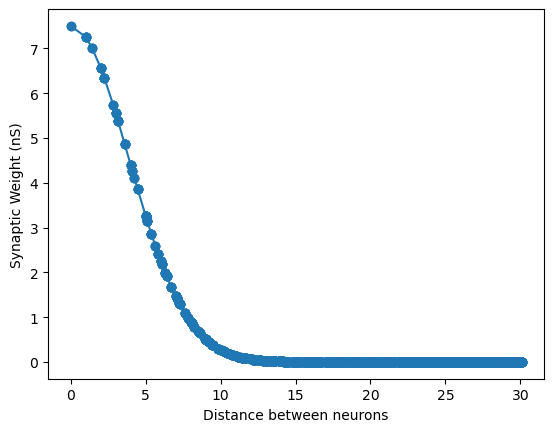

In [6]:
pos = nest.GetPosition(l_exc)
offset = l_exc[0].global_id
src_nrn = 0
conns = nest.GetConnections(source=l_exc[src_nrn], target = l_exc)
tgts = conns.target
weights = conns.weight
dists = np.squeeze([nest.Distance(l_exc[src_nrn], l_exc[tgt-offset]) for tgt in tgts])
plt.scatter(dists, weights)
x = np.sort(dists)
plt.plot(x, W_E*np.exp(-x**2/sigma_ex))
plt.xlabel('Distance between neurons')
plt.ylabel('Synaptic Weight (nS)')

## Run Simulation

In [7]:
nest.Simulate(1000)


Aug 28 13:57:07 NodeManager::prepare_nodes [Info]: 
    Preparing 10004 nodes for simulation.

Aug 28 13:57:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10004
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 28 13:58:44 SimulationManager::run [Info]: 
    Simulation finished.


Text(0.5, 1.0, 'Spike Raster')

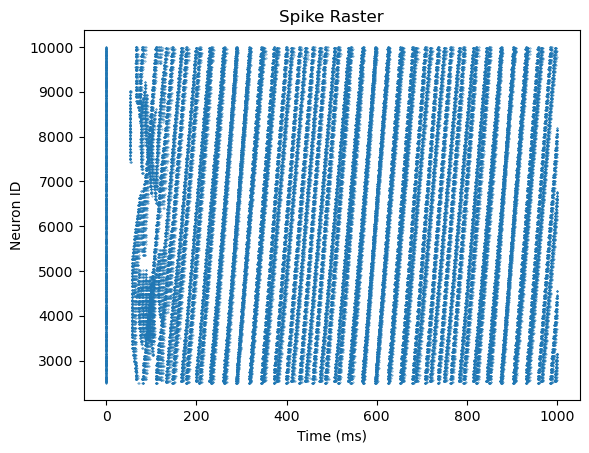

In [8]:
plt.scatter(spikedetector_exc.events['times'],spikedetector_exc.events['senders'], s = 0.1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Spike Raster')

  0%|          | 0/99 [00:00<?, ?it/s]

Generating Animation. 99 frames in total.


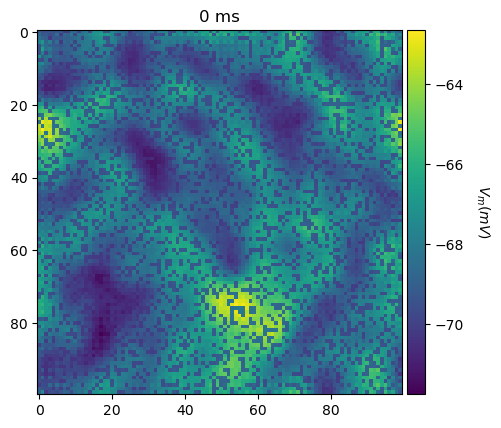

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from IPython.display import HTML
from tqdm.notebook import tqdm

t = 1.
coords = np.array(nest.GetPosition(l_inh) + nest.GetPosition(l_exc))
grid_coords = (coords - np.min(coords)).astype('int')
img_array = np.zeros((n,n))
volts = voltmeter.events['V_m'][voltmeter.events['times']==t]
# plt.scatter(grid_coords[:,0], coords[:,1], c = volts)
img_array[grid_coords[:,0], grid_coords[:,1]] = volts

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(img_array, aspect='equal')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)

# Append axes to the right of the current axis, with 5% width of ax
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create the colorbar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$V_m (mV)$', rotation=270, labelpad=20)



frameinterval = 10
totalframes = int(nest.biological_time/frameinterval)-1
p_bar = tqdm(range(totalframes))
def animate(i):
    volts = voltmeter.events['V_m'][voltmeter.events['times']==(i+1)*frameinterval]
    # plt.scatter(grid_coords[:,0], coords[:,1], c = volts)
    img_array[grid_coords[:,0], grid_coords[:,1]] = volts
    
    ax.cla()

    ax.set_title('{:.0f} ms'.format(i*frameinterval))
    cbar.set_label('$V_m (mV)$', rotation=270, labelpad=20)
    ax.imshow(img_array, aspect='equal')
    p_bar.update(1)

ani = animation.FuncAnimation(fig, animate, frames=totalframes,interval=100)
print(f'Generating Animation. {totalframes} frames in total.')
HTML(ani.to_jshtml()) 